#**Benchmark**

#**Section 1: Import Important Library**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import seaborn as sns
import itertools
import psutil

import cv2
import shutil
import PIL
import os
from pathlib import Path
import sys

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder, LabelBinarizer

import random as rd
import numpy as np
import zipfile

In [ ]:
import tensorflow as tf
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Detail of Python Notebook in Google Colab**

In [ ]:
!nvidia-smi

import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Mon Aug 25 14:53:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Initialize Setting (Focus First)**

In [ ]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)
BATCH_SIZE = 16

In [ ]:
root_dir = '/content/drive/MyDrive/projectPlant/'
title = 'Maize Dataset'
dataset_name = 'maizeDataset'
dataset_dir = root_dir + dataset_name

In [ ]:
current_dir = os.getcwd()

In [ ]:
zip_filename = 'maize_dataset_raw.zip'
zip_dir = dataset_dir + '/' + zip_filename

with zipfile.ZipFile(zip_dir, 'r') as zip_ref: # แตกไฟล์จาก G-Drive มาที่ Runtime Directory
    zip_ref.extractall(current_dir)
print(f"Unzip complete at {current_dir}")

Unzip complete at /content


In [ ]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


#**Section 2: Load Dataset**

In [ ]:
train_dir = current_dir + '/train_smp'
test_dir = current_dir + '/pred_img'

In [ ]:
selector = f'{dataset_name}4Classes'
model_name = 'MBNv3Small_Mini_Modify_B'
otmz_name = 'Adam'
seed_num = f"{SEED}"
rounds_num = '1'

In [ ]:
img_dir = root_dir + 'Extra2/' + dataset_name
sample_img_dir = img_dir + '/SampleImages'
img_each_model_dir = img_dir + '/' + model_name + '_' + dataset_name + '_' + otmz_name + '_' + seed_num + '(' + rounds_num + ')'
excel_dir = root_dir + 'DatasetSetting/' + dataset_name + '/' + 'split_data_seed_' + seed_num + '.xlsx'

In [ ]:
os.makedirs(img_dir, exist_ok=True)
os.makedirs(sample_img_dir, exist_ok=True)
os.makedirs(img_each_model_dir, exist_ok=True)

#**Section 3: Placing data into a Dataframe**

##**Label mapping**

In [ ]:
labels_mapping = mapping(selector)
print(labels_mapping)

{'1': 'Phaeosphaeria spot', '2': 'Corn Eyespot', '3': 'Gray Leaf Spot', '4': "Goss's Bacterial wilt"}


##**Convert to dataframe**

In [ ]:
TRAIN_DF, VALID_DF = to_dataframe_excel(path=excel_dir, sheet_name='Split-Data', mode='multi', condition=False, labels_mapping=labels_mapping)

In [ ]:
print(f"Train Dataframe\n")
print(f"Total images: {len(TRAIN_DF)}")
print(f"Total classes: {TRAIN_DF['Label'].nunique()}")
TRAIN_DF

Train Dataframe

Total images: 280
Total classes: 4


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,157
1,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,109
2,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,17
3,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot,347
4,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,24
...,...,...,...
275,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,71
276,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,106
277,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,270
278,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot,348


In [ ]:
TRAIN_DF["Filepath"] = TRAIN_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/maizeDataset/",
    "/content/"
)
TRAIN_DF

,Filepath,Label,Original_Index
0,/content/train_smp/3_36.jpg,Gray Leaf Spot,157
1,/content/train_smp/3_77.jpg,Gray Leaf Spot,109
2,/content/train_smp/4_87.jpg,Goss's Bacterial wilt,17
3,/content/train_smp/1_38.jpg,Phaeosphaeria spot,347
4,/content/train_smp/4_7.jpg,Goss's Bacterial wilt,24
...,...,...,...
275,/content/train_smp/4_45.jpg,Goss's Bacterial wilt,71
276,/content/train_smp/3_9.jpg,Gray Leaf Spot,106
277,/content/train_smp/2_100.jpg,Corn Eyespot,270
278,/content/train_smp/1_47.jpg,Phaeosphaeria spot,348


In [ ]:
print(f"Validation Dataframe\n")
print(f"Total images: {len(VALID_DF)}")
print(f"Total classes: {VALID_DF['Label'].nunique()}")
VALID_DF

Validation Dataframe

Total images: 120
Total classes: 4


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,209
1,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,280
2,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,33
3,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,210
4,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,93
...,...,...,...
115,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,60
116,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,79
117,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,285
118,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot,305


In [ ]:
VALID_DF["Filepath"] = VALID_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/maizeDataset/",
    "/content/"
)
VALID_DF

,Filepath,Label,Original_Index
0,/content/train_smp/2_92.jpg,Corn Eyespot,209
1,/content/train_smp/2_30.jpg,Corn Eyespot,280
2,/content/train_smp/4_75.jpg,Goss's Bacterial wilt,33
3,/content/train_smp/2_69.jpg,Corn Eyespot,210
4,/content/train_smp/3_88.jpg,Gray Leaf Spot,93
...,...,...,...
115,/content/train_smp/4_27.jpg,Goss's Bacterial wilt,60
116,/content/train_smp/4_22.jpg,Goss's Bacterial wilt,79
117,/content/train_smp/2_15.jpg,Corn Eyespot,285
118,/content/train_smp/1_80.jpg,Phaeosphaeria spot,305


In [ ]:
TEST_DF = to_dataframe(test_dir, mode='multi', condition=True, labels_mapping=labels_mapping)
TEST_DF

Total images: 81
Total classes: 4


,Filepath,Label
0,/content/pred_img/3_8.jpg,Gray Leaf Spot
1,/content/pred_img/4_17.jpg,Goss's Bacterial wilt
2,/content/pred_img/1_16.jpg,Phaeosphaeria spot
3,/content/pred_img/4_11.jpg,Goss's Bacterial wilt
4,/content/pred_img/4_20.jpg,Goss's Bacterial wilt
...,...,...
76,/content/pred_img/1_3.jpg,Phaeosphaeria spot
77,/content/pred_img/2_12.jpg,Corn Eyespot
78,/content/pred_img/3_7.jpg,Gray Leaf Spot
79,/content/pred_img/4_5.jpg,Goss's Bacterial wilt


#**Section 4: Data Preparing**

In [ ]:
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (224, 224, 3)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

valid_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = TRAIN_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

val_images = valid_test_generator.flow_from_dataframe(
    dataframe = VALID_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

test_images = valid_test_generator.flow_from_dataframe(
    dataframe = TEST_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 280 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.


#**Section 5: Preparing the Model**

In [ ]:
checkpoint_path, save_path_h5, save_path_keras, save_path_json, save_path_history, save_path_tensorboard = save_path(otmz_name=otmz_name, dataset_name=dataset_name, rounds=rounds_num, model=model_name, seed=SEED)
print("Recheck save path: \n")
print(f"Checkpoint path: {checkpoint_path}")
print(f"Save path h5: {save_path_h5}")
print(f"Save path keras: {save_path_keras}")
print(f"Save path json: {save_path_json}")
print(f"Save path history: {save_path_history}")
print(f"Save path tensorboard: {save_path_tensorboard}")

Recheck save path: 

Checkpoint path: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1)_best.keras
Save path h5: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).h5
Save path keras: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).keras
Save path json: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).json
Save path history: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).csv
Save path tensorboard: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_

##**Create Model Callback**

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto'
)

class LearningRateTracker(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Access learning rate through learning_rate property
        lr = self.model.optimizer.learning_rate.numpy()  # This will now work correctly
        logs = logs or {}
        logs['lr'] = lr

        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)

# Create the callback instance
lr_tracker = LearningRateTracker()

tensorlog = keras.callbacks.TensorBoard(
    log_dir = save_path_tensorboard,
    histogram_freq = 1,
    write_graph = True,
    write_images = True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 5,
    verbose = 1,
    min_lr = 1e-06
)

##**Model Parameters**

In [ ]:
chao_kuay_model = build_model(model_name="MobileNetV3SmallMinimalistic_Modify_B", input_shape=IMAGE_SHAPE, num_classes=len(train_images.class_indices))
chao_kuay_model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = 1e-04,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-07,
        name = 'Adam'
    ),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
chao_kuay_model.summary()

2128592/2128592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ re_lu[0][0]       │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ re_lu_1[0][0]     │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 56, 56,    │      1,152 │ expanded_conv_pr… │
│ (Conv2D)            │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 56, 56,    │        288 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ expanded_conv_1_… │
│                     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 57, 57,    │          0 │ re_lu_2[0][0]     │
│ (ZeroPadding2D)     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 28, 28,    │        648 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 28, 28,    │        288 │ expanded_conv_1_

 Total params: 401,836 (1.53 MB)

 Trainable params: 252,100 (984.77 KB)

 Non-trainable params: 149,736 (584.91 KB)

#**Section 6: Training the model**

In [ ]:
start_time_training = time()

history = chao_kuay_model.fit(
    x = train_images,
    validation_data = val_images,
    batch_size = BATCH_SIZE,
    callbacks = [model_checkpoint, tensorlog, lr_tracker, reduce_lr],
    epochs = 30,
)

end_time_training = time()

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.3332 - loss: 1.3186
Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1)_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3388 - loss: 1.3115 - val_accuracy: 0.2667 - val_loss: 1.3868 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7348 - loss: 0.8632
Epoch 2: val_accuracy did not improve from 0.26667
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.7350 - loss: 0.8601 - val_accuracy: 0.2667 - val_loss: 1.4600 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8147 - loss: 0.6534
Epoch 3: val_accuracy did not improve from 0.26667
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.8154 - loss: 0.6515 - val_accuracy: 0.2667 - val_loss: 1.5514 - learning

In [ ]:
history_dict = history.history
print(f"History: {history_dict}")

History: {'accuracy': [0.4392857253551483, 0.7392857074737549, 0.8285714387893677, 0.8464285731315613, 0.9178571701049805, 0.9392856955528259, 0.9571428298950195, 0.949999988079071, 0.9678571224212646, 0.9607142806053162, 0.9821428656578064, 0.9928571581840515, 0.9857142567634583, 0.9785714149475098, 0.9857142567634583, 0.9750000238418579, 0.9964285492897034, 0.9964285492897034, 0.9964285492897034, 0.9821428656578064, 0.9928571581840515, 0.9750000238418579, 0.9928571581840515, 0.9928571581840515, 0.9964285492897034, 0.9928571581840515, 1.0, 0.9964285492897034, 0.9928571581840515, 1.0], 'loss': [1.1834267377853394, 0.8036364316940308, 0.6174969673156738, 0.4177555441856384, 0.31257981061935425, 0.2209622859954834, 0.19811177253723145, 0.1661931574344635, 0.12242724746465683, 0.12158400565385818, 0.08111338317394257, 0.07265020906925201, 0.07437233626842499, 0.07461494952440262, 0.058487892150878906, 0.07388278096914291, 0.0363110676407814, 0.04296194389462471, 0.028580443933606148, 0.03

In [ ]:
training_time = end_time_training - start_time_training
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Training time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Training time: 0 hours, 3 minutes, 51.53 seconds


##**Save the model**

In [ ]:
save_epoch_history(history, save_path_history)

History has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).csv


In [ ]:
save_model(chao_kuay_model, save_path_h5, save_path_keras, save_path_json)

Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).keras
Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).h5
Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini_Modify_B/maizeDataset_42(1)/Adam/MBNv3Small_Mini_Modify_B_maizeDataset_Adam_42(1).json


#**Section 7: Model Evaluation**

In [ ]:
start_time_evaluate = time()
test_acc = chao_kuay_model.evaluate(test_images, verbose=1)
print(f"Final Test Accuracy: {test_acc[1]}, Final Test Loss: {test_acc[0]}")
end_time_evaluate = time()
evaluate_time = end_time_evaluate - start_time_evaluate
hours, remainder = divmod(evaluate_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Evaluation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8678 - loss: 0.6329
Final Test Accuracy: 0.8518518805503845, Final Test Loss: 0.7333073019981384
Evaluation time: 0 hours, 0 minutes, 20.54 seconds


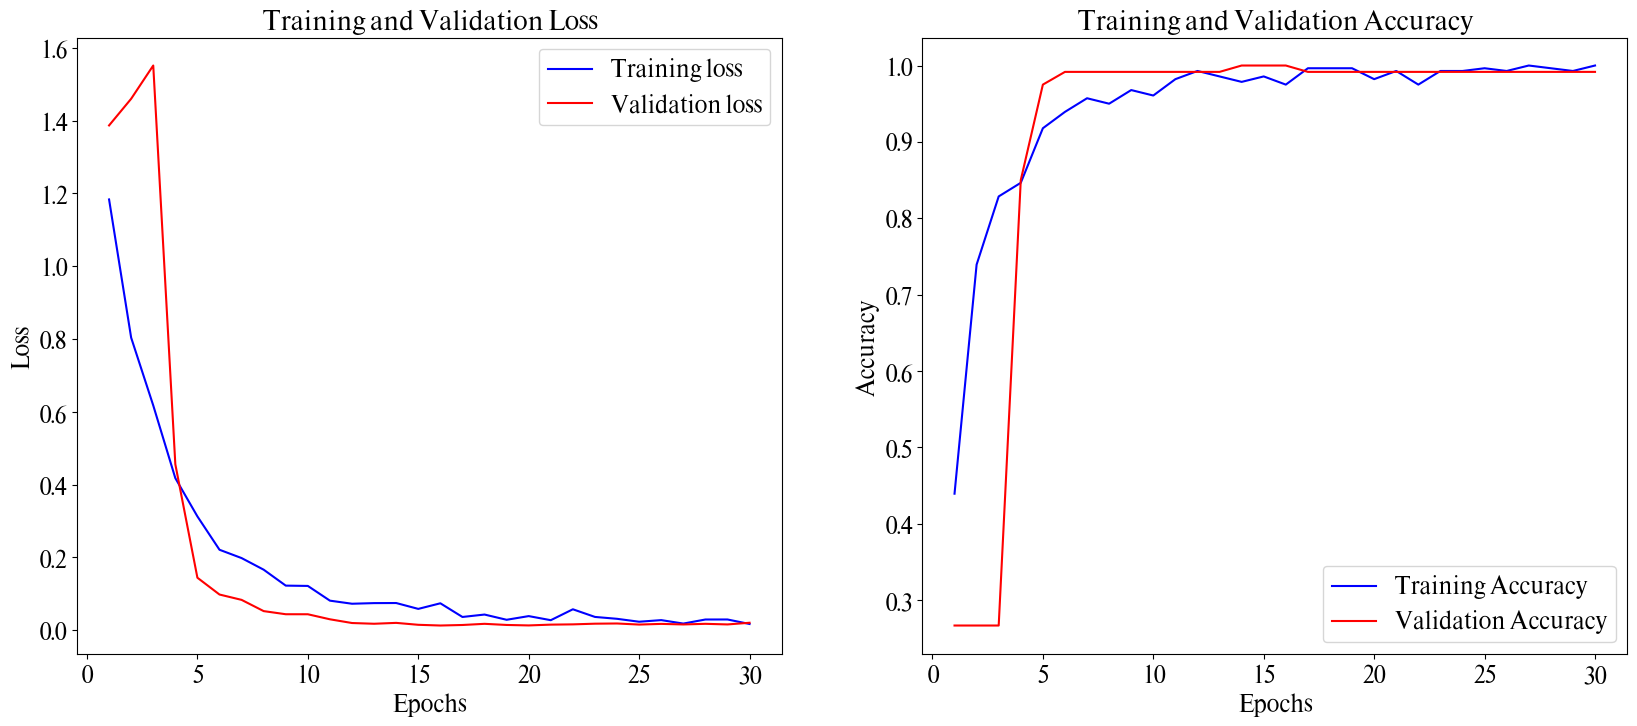

In [ ]:
tr_plot_no_best_epoch(history, 0, paths=img_each_model_dir)

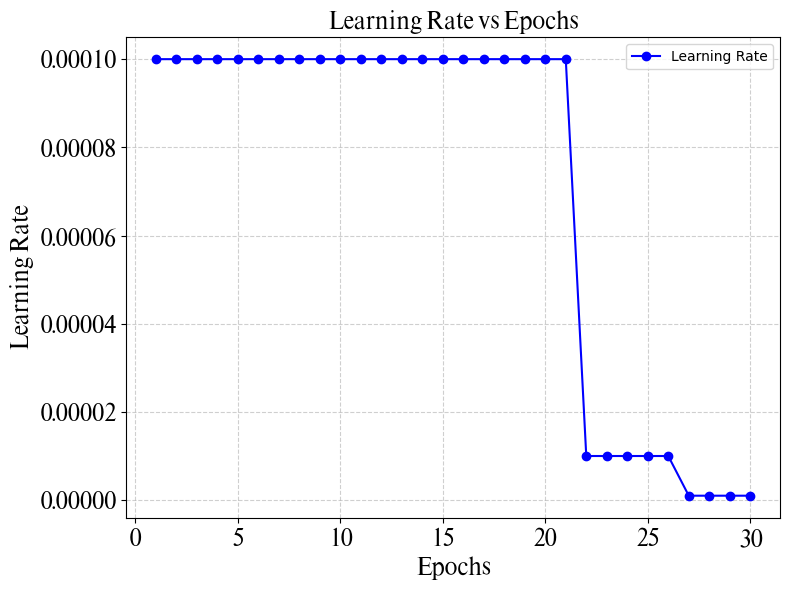

In [ ]:
lr_plot(lr_tracker, history, paths=img_each_model_dir)

#**Section 8: Making predictions on the Predict Data**

In [ ]:
# พยากรณ์ผลลัพธ์จากโมเดล
predictions = chao_kuay_model.predict(test_images)
# แปลงผลลัพธ์เป็น index ของ class ที่มีค่าความน่าจะเป็นสูงสุด
predicted_indices = np.argmax(predictions, axis=1)
# ดึงข้อมูล mapping ระหว่าง index กับ class name จาก training set
class_index_mapping = train_images.class_indices
# สลับ key กับ value เพื่อแปลงจาก index กลับไปเป็นชื่อ class
index_to_class = dict((v, k) for k, v in class_index_mapping.items())
# แปลง predicted index ให้เป็นชื่อ class ที่เกี่ยวข้อง
predicted_classes = [index_to_class[index] for index in predicted_indices]

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


##**Misclass Predicted**

In [ ]:
incorrect_index = [i for i in range(len(TEST_DF)) if TEST_DF.Label.iloc[i] != predicted_classes[i]]

# สร้าง DataFrame ใหม่ที่มีเฉพาะแถวที่ทำนายผิด
misclassified_df = TEST_DF.iloc[incorrect_index].copy()
# เพิ่มคอลัมน์ Predicted Label ลงใน DataFrame
misclassified_df['Predicted Label'] = [predicted_classes[i] for i in incorrect_index]  # เปลี่ยนชื่อให้ตรงกับที่ต้องการ
# เลือกคอลัมน์ Filepath, Label (True Label), และ Predicted Label
result_misclass_df = misclassified_df[['Filepath', 'Label', 'Predicted Label']]
# เปลี่ยนชื่อคอลัมน์ Label เป็น True Label
result_misclass_df = result_misclass_df.rename(columns={'Label': 'True Label'})

print("Misclassified Dataframe Detail:")
result_misclass_df

Misclassified Dataframe Detail:


,Filepath,True Label,Predicted Label
3,/content/pred_img/4_11.jpg,Goss's Bacterial wilt,Corn Eyespot
15,/content/pred_img/2_17.jpg,Corn Eyespot,Phaeosphaeria spot
16,/content/pred_img/3_11.jpg,Gray Leaf Spot,Corn Eyespot
34,/content/pred_img/4_15.jpg,Goss's Bacterial wilt,Corn Eyespot
47,/content/pred_img/4_16.jpg,Goss's Bacterial wilt,Phaeosphaeria spot
48,/content/pred_img/3_13.jpg,Gray Leaf Spot,Phaeosphaeria spot
51,/content/pred_img/3_17.jpg,Gray Leaf Spot,Corn Eyespot
55,/content/pred_img/4_18.jpg,Goss's Bacterial wilt,Corn Eyespot
59,/content/pred_img/4_13.jpg,Goss's Bacterial wilt,Corn Eyespot
63,/content/pred_img/3_18.jpg,Gray Leaf Spot,Corn Eyespot


In [ ]:
y_test = list(TEST_DF.Label)
report = classification_report(y_test, predicted_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Corn Eyespot,0.714286,0.952381,0.816327,21.000000
Goss's Bacterial wilt,1.000000,0.700000,0.823529,20.000000
Gray Leaf Spot,1.000000,0.761905,0.864865,21.000000
Phaeosphaeria spot,0.826087,1.000000,0.904762,19.000000
accuracy,0.851852,0.851852,0.851852,0.851852
macro avg,0.885093,0.853571,0.852371,81.000000
weighted avg,0.885132,0.851852,0.851433,81.000000


##**Plot ROC Curve**

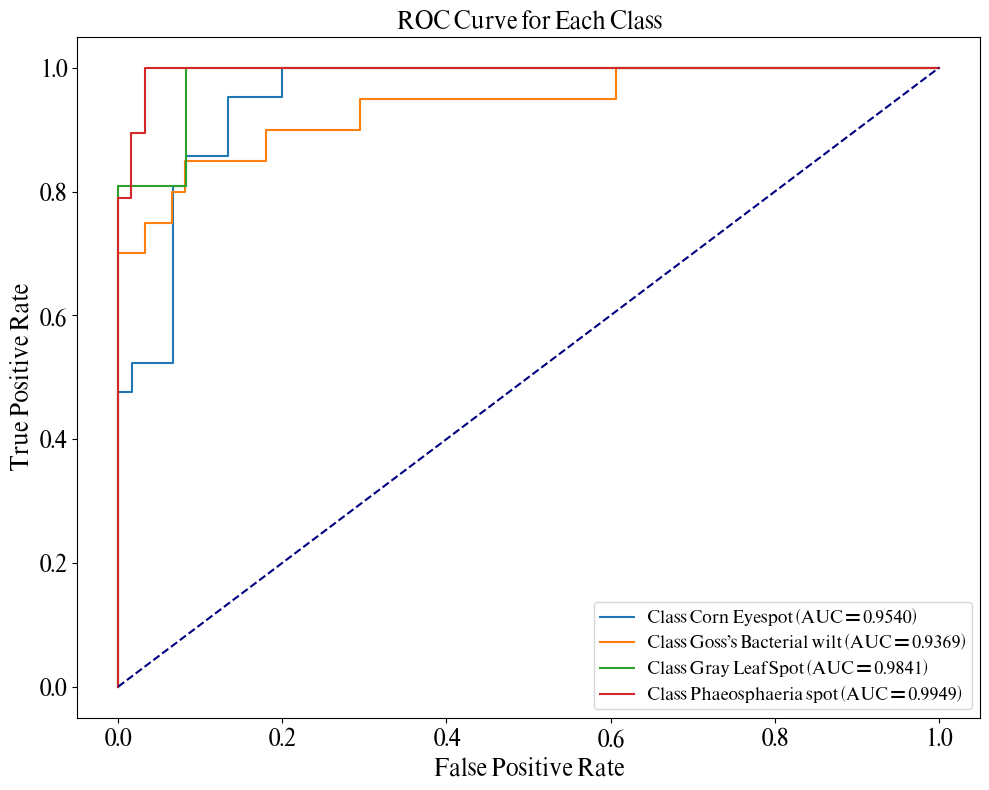

In [ ]:
plot_roc_curve(y_test, predictions, paths=img_each_model_dir)

##**Plot Confusion Matrix**

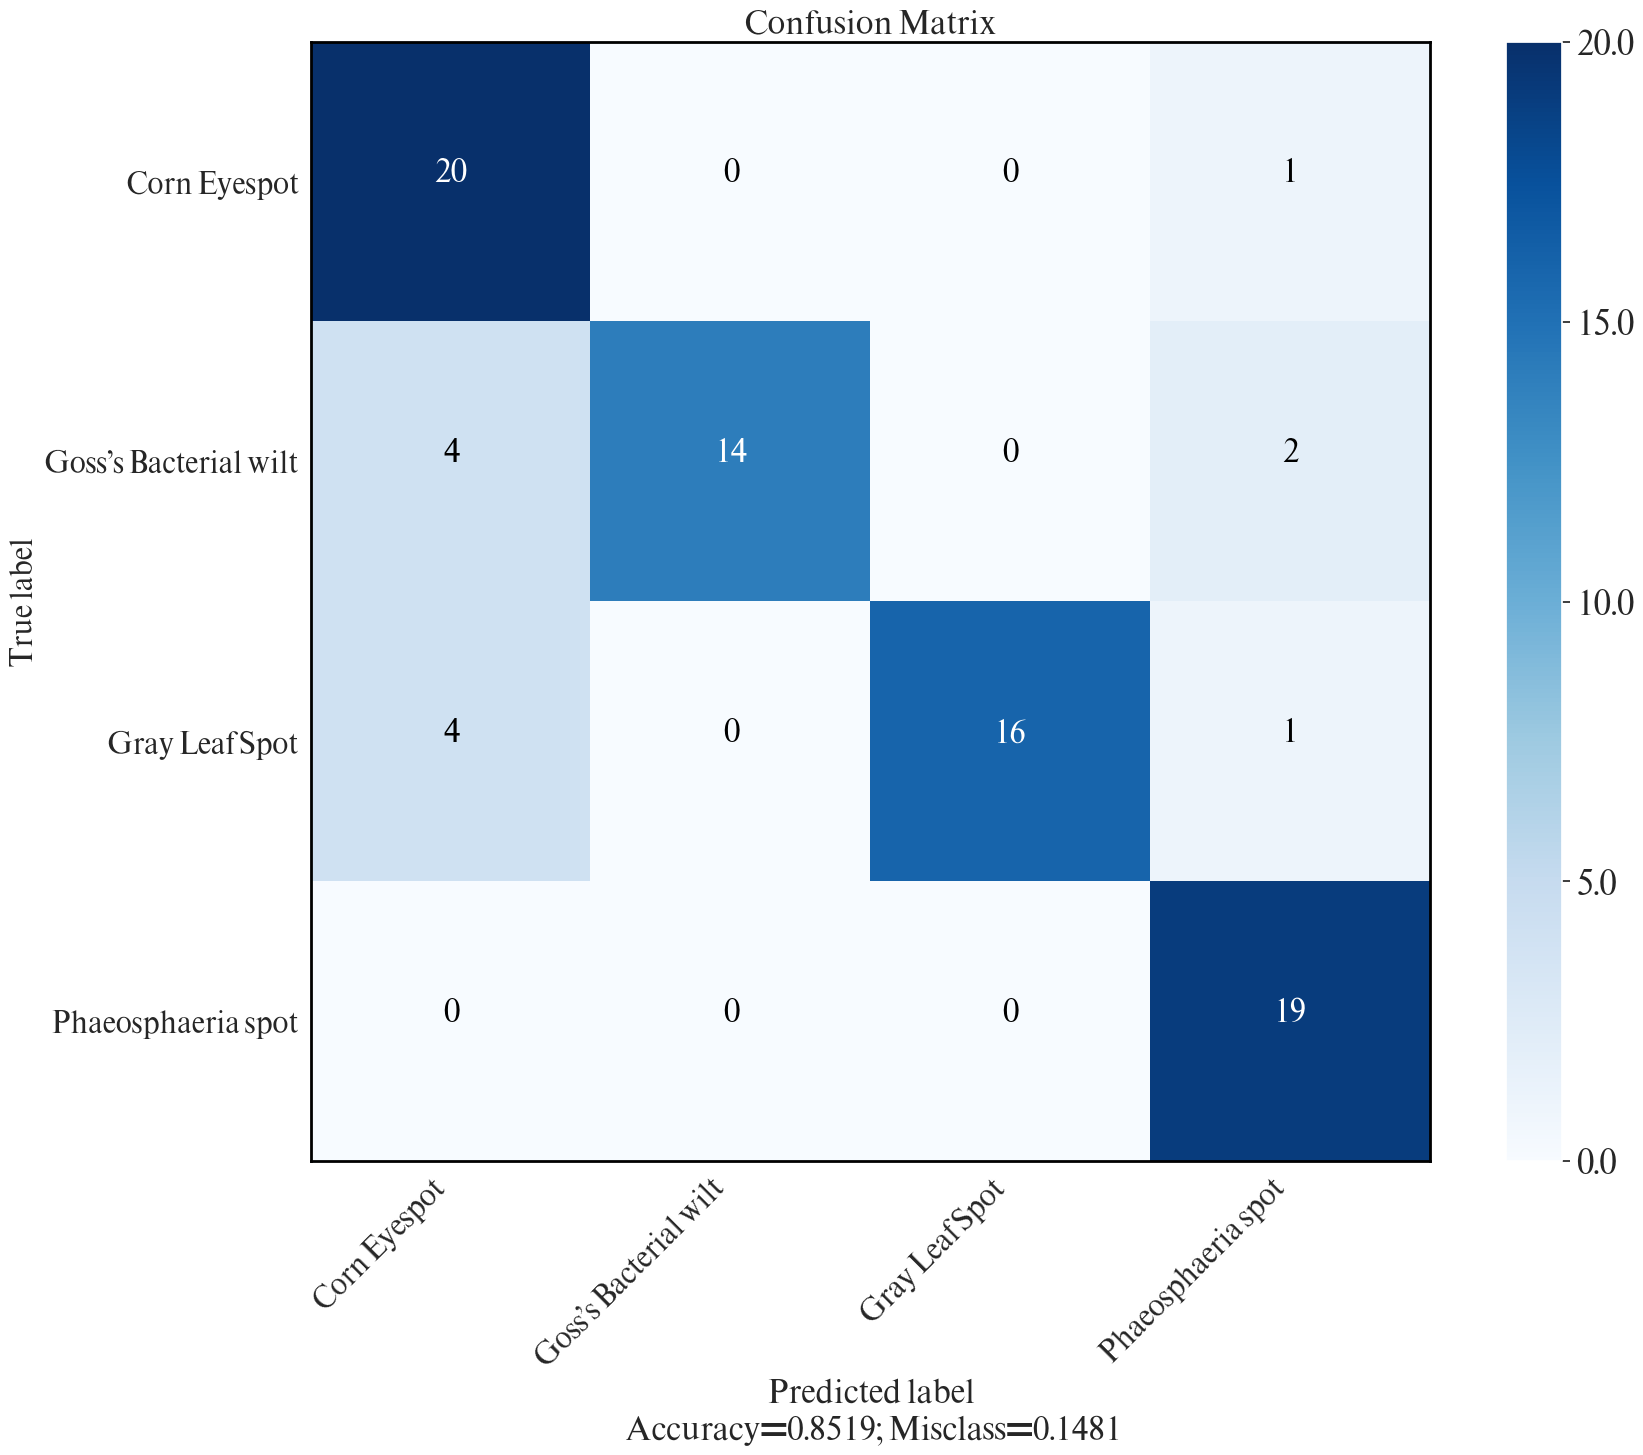

In [ ]:
target_names = list(index_to_class.values())
cm = confusion_matrix(y_test, predicted_classes)
plot_confusion_matrix(cm=cm, target_names=target_names, title='Confusion Matrix', fontsize=20, paths=img_each_model_dir)

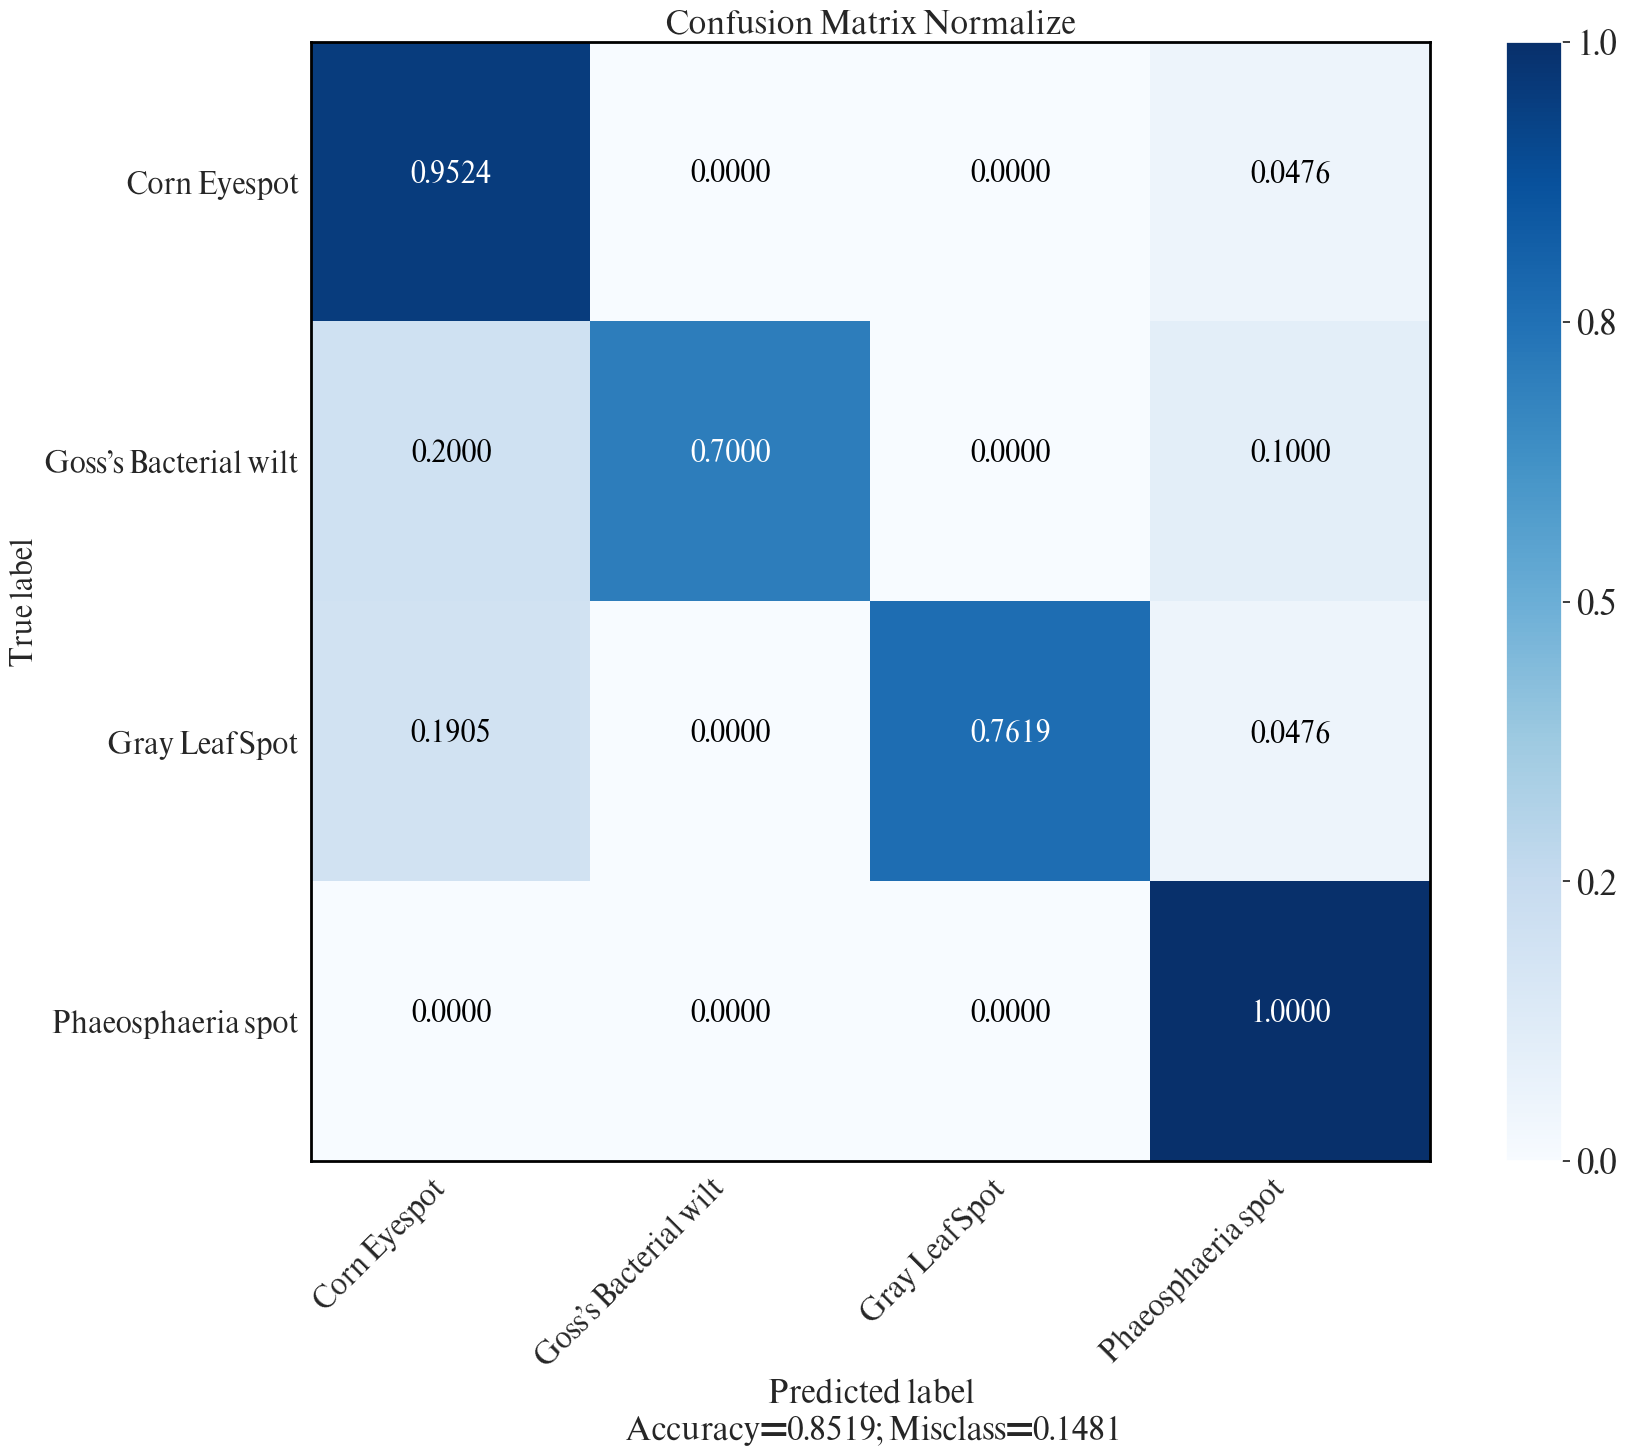

In [ ]:
plot_confusion_matrix(cm=cm, target_names=target_names, title='Confusion Matrix Normalize', normalize = True, fontsize=20, paths=img_each_model_dir)

##**Load Model Test**

In [ ]:
load_model = keras.saving.load_model(save_path_keras)

In [ ]:
start_time_evaluate = time()
test_acc_load = load_model.evaluate(test_images, verbose=1)
print(f"Final Test Accuracy: {test_acc_load[1]}, Final Test Loss: {test_acc_load[0]}")
end_time_evaluate = time()
evaluate_time = end_time_evaluate - start_time_evaluate
hours, remainder = divmod(evaluate_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Evaluation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 661ms/step - accuracy: 0.8678 - loss: 0.6329
Final Test Accuracy: 0.8518518805503845, Final Test Loss: 0.7333073019981384
Evaluation time: 0 hours, 0 minutes, 12.39 seconds
